In [ ]:
!rm -rf /content/dataset

In [ ]:
!rm -rf /content/__MACOSX

In [ ]:
!mkdir -p /content/dataset

In [ ]:
!rm /content/final_data.zip

In [ ]:
# @title 1. Setup, Extract & Environment
import os
import zipfile
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import copy
import matplotlib.pyplot as plt
import numpy as np

# MODIFICATION: Added Gradio library for the interactive UI at the end.
try:
    import gradio as gr
except ImportError:
    !pip install gradio -q
    import gradio as gr

# --- CONFIGURATION ---
zip_path = '/content/final_data.zip'
extract_path = '/content/dataset'
data_dir = os.path.join(extract_path, 'final_data_v2')

# 1. CLEAN & EXTRACT
if os.path.exists(extract_path): shutil.rmtree(extract_path)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 2. CLEAN HIDDEN MAC FILES
macosx_path = os.path.join(extract_path, '__MACOSX')
if os.path.exists(macosx_path): shutil.rmtree(macosx_path)
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.startswith('._'): os.remove(os.path.join(root, file))

In [ ]:
# 3. TRANSFORMS (Data Augmentation)
# MODIFICATION: Increased augmentation (Rotation, ColorJitter).
# Explanation: A custom CNN learns from scratch. It needs more diverse augmented data to avoid memorizing the training images compared to a pre-trained ResNet.
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# @title 2. Data Selection & Splitting
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class_names = full_dataset.classes

In [ ]:
# @title 3. Define Custom CNN Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🧠 Using device: {device}")

# MODIFICATION: Replaced ResNet-50 with a Custom CNN.
# Explanation: This demonstrates architectural design knowledge. It uses Convolutional layers to extract features and fully connected (Linear) layers to classify them.

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Conv Block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Stabilizes training
        # Conv Block 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Conv Block 3
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.dropout = nn.Dropout(0.5) # Prevents overfitting
        self.fc2 = nn.Linear(512, len(class_names))

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 28 * 28) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

model = CustomCNN().to(device)

# MODIFICATION: Lowered Learning Rate to 0.0005.
# Explanation: Custom models training from scratch require a smaller learning rate than pre-trained transfer learning models to ensure the gradients don't explode.
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

🧠 Using device: cuda


In [ ]:
# @title 4. Train Model with Early Stopping
# MODIFICATION: Implemented Early Stopping and Model Checkpointing.
# Explanation: Instead of running a fixed number of epochs and potentially overfitting, this monitors validation accuracy. If it stops improving, training halts and the BEST version is saved.

epochs = 30
patience = 3
best_acc = 0.0
patience_counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

history = {'train_loss': [], 'val_acc': []}

print(f"\n🚀 Training starting with Early Stopping (Patience = {patience})...")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation Phase
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Early Stopping Logic
    if val_acc > best_acc:
        print(f"   🌟 Val Acc improved ({best_acc:.2f}% -> {val_acc:.2f}%). Saving model...")
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_custom_cnn.pth') # Saves best weights physically
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"   ⚠️ No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch+1}!")
            break

# Load the best weights before doing evaluation or UI
print(f"\n✅ Loading best model weights (Val Acc: {best_acc:.2f}%)")
model.load_state_dict(best_model_wts)


🚀 Training starting with Early Stopping (Patience = 3)...
Epoch 1/30 | Train Loss: 7.2217 | Val Acc: 84.34%
   🌟 Val Acc improved (0.00% -> 84.34%). Saving model...
Epoch 3/30 | Train Loss: 0.4460 | Val Acc: 84.94%
   🌟 Val Acc improved (84.34% -> 84.94%). Saving model...
Epoch 4/30 | Train Loss: 0.4024 | Val Acc: 87.35%
   🌟 Val Acc improved (84.94% -> 87.35%). Saving model...
Epoch 5/30 | Train Loss: 0.3975 | Val Acc: 85.54%
   ⚠️ No improvement. Patience: 1/3
Epoch 6/30 | Train Loss: 0.3813 | Val Acc: 89.76%
   🌟 Val Acc improved (87.35% -> 89.76%). Saving model...
Epoch 7/30 | Train Loss: 0.3798 | Val Acc: 87.95%
   ⚠️ No improvement. Patience: 1/3
Epoch 8/30 | Train Loss: 0.3470 | Val Acc: 90.96%
   🌟 Val Acc improved (89.76% -> 90.96%). Saving model...
Epoch 9/30 | Train Loss: 0.3446 | Val Acc: 88.55%
   ⚠️ No improvement. Patience: 1/3
Epoch 10/30 | Train Loss: 0.2965 | Val Acc: 90.36%
   ⚠️ No improvement. Patience: 2/3
Epoch 11/30 | Train Loss: 0.2865 | Val Acc: 82.53%
   ⚠️ 

<All keys matched successfully>

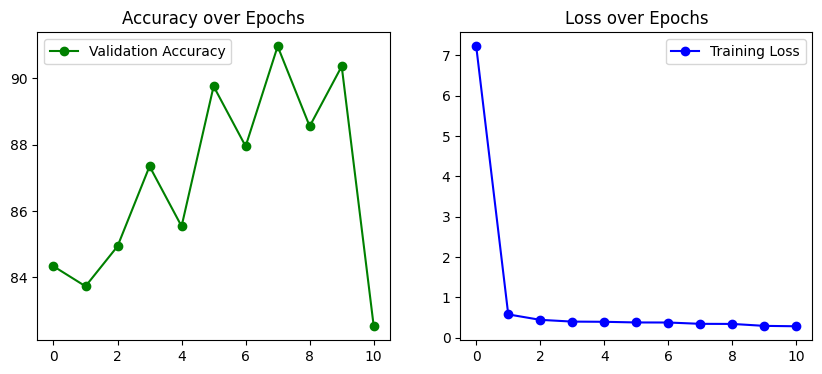

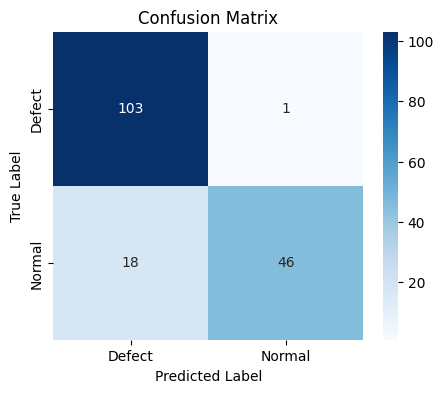

In [ ]:
# @title 5. Final Evaluation & Plots
# Plotting the training curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['val_acc'], label='Validation Accuracy', color='green', marker='o')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Training Loss', color='blue', marker='o')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# MODIFICATION: Added Confusion Matrix for report analysis.
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

🖼️ Visualizing 8 random test images and analyzing defect rates...

📊 BATCH ANALYSIS (8 IMAGES)
Model Error Rate on this batch : 12.5%
Detected Rates (Predictions)   :
   - Defect: 6/8 (75.0%)
   - Normal: 2/8 (25.0%)



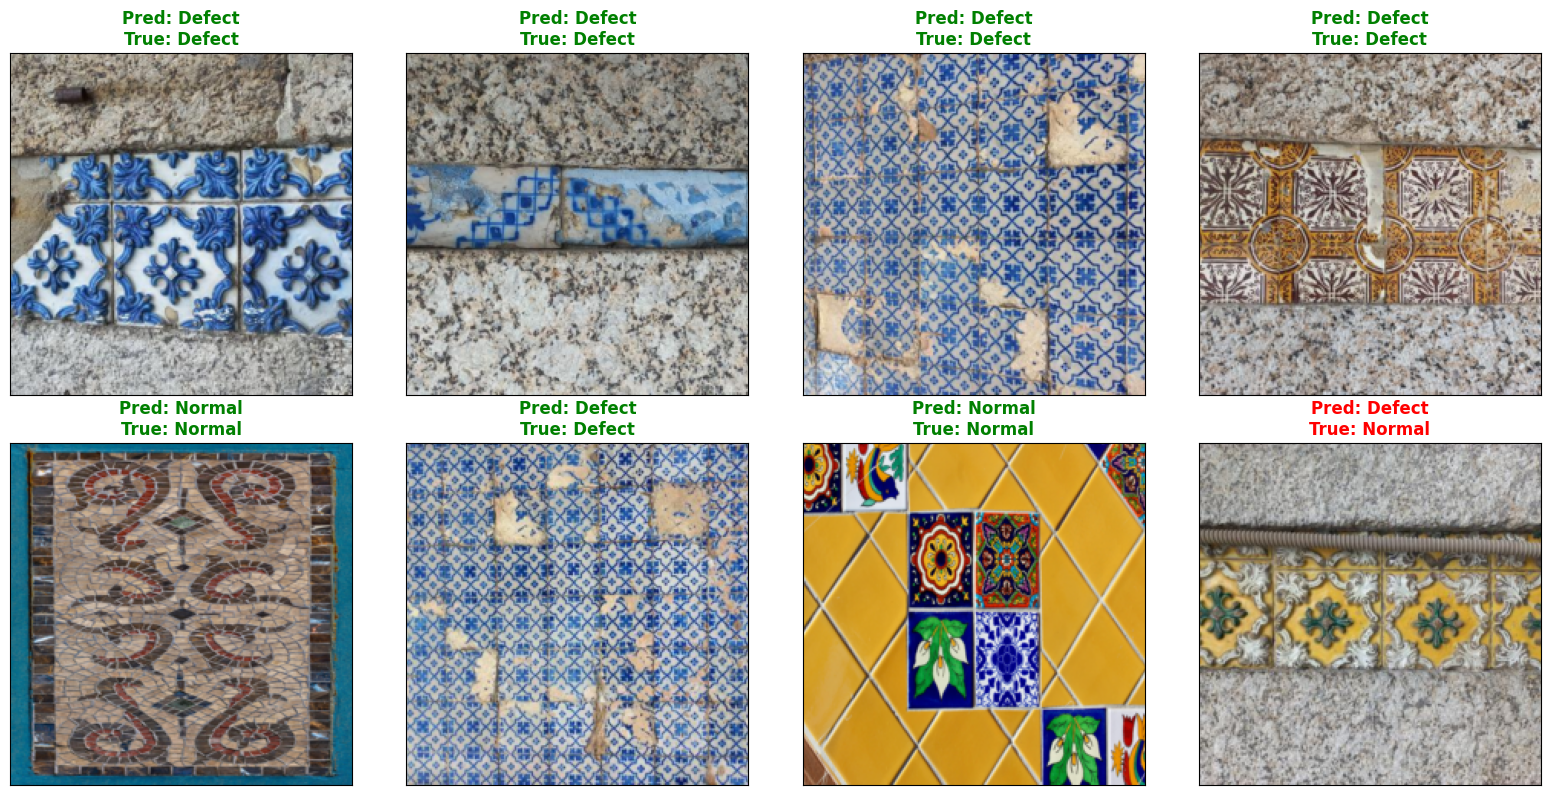

In [ ]:
# @title 5.5 Qualitative Visualization & Batch Defect Rate
import numpy as np
import matplotlib.pyplot as plt
import torch

print("🖼️ Visualizing 8 random test images and analyzing defect rates...")

# 1. Grab a single batch of images from the test_loader
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Select only the first 8 images from the batch
images = images[:8]
labels = labels[:8]

# 2. Get predictions for this batch
model.eval()
with torch.no_grad():
    # Model generates predictions on the GPU
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)

    # FIX: Move predictions back to the CPU so they can be compared with labels
    preds = preds.cpu()

# 3. Calculate Defect Rate / Class Distribution for the 8 images
correct_predictions = (preds == labels).sum().item()
error_rate = 100 - ((correct_predictions / len(images)) * 100)

pred_counts = {classname: 0 for classname in class_names}
for p in preds:
    pred_counts[class_names[p.item()]] += 1

print("\n" + "="*40)
print("📊 BATCH ANALYSIS (8 IMAGES)")
print("="*40)
print(f"Model Error Rate on this batch : {error_rate:.1f}%")
print("Detected Rates (Predictions)   :")
for c_name, count in pred_counts.items():
    rate = (count / len(images)) * 100
    print(f"   - {c_name}: {count}/8 ({rate:.1f}%)")
print("="*40 + "\n")

# 4. Plot the images in a 2x4 grid
fig = plt.figure(figsize=(16, 8))

for idx in np.arange(len(images)):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])

    # Un-normalize the image so it looks correct to the human eye
    img = images[idx].cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1) # Ensure pixel values are strictly between 0 and 1

    # Display the image
    ax.imshow(img)

    # Determine text color: Green if prediction matches label, Red if wrong
    pred_class = class_names[preds[idx].item()]
    true_class = class_names[labels[idx].item()]
    text_color = "green" if preds[idx].item() == labels[idx].item() else "red"

    # Add title showing Prediction vs True label
    ax.set_title(f"Pred: {pred_class}\nTrue: {true_class}", color=text_color, fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# @title 6. Gradio UI Deployment
# MODIFICATION: Created an interactive web interface using the best saved model.
def predict_image(img):
    # Convert incoming array to PIL Image, then tensor
    img = Image.fromarray(img.astype('uint8'), 'RGB')
    img = val_transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        prediction = torch.nn.functional.softmax(model(img)[0], dim=0)
        # Map probabilities back to class names
        return {class_names[i]: float(prediction[i]) for i in range(len(class_names))}

demo = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(),
    outputs=gr.Label(num_top_classes=2),
    title="Instrument Classifier (Custom CNN)",
    description="Upload an image to test the Custom Convolutional Neural Network's predictions."
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://65cb0c28a29c5cdc16.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
